# Summary

This notebook allows to replicate the results in terms of execution time comparing the neural network with traditional clustering and internal score.

In [1]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from sklearn import mixture
import hdbscan
import random
from tqdm import tqdm
import os
import sys
from keras.models import Model
import time
from keras.models import load_model
import scripts.cnn_models as cnn_models
import scripts.internal_scores as validation

plt.ion()
plt.show()
random_state=0
random.seed( random_state )
np.random.seed(random_state)
method = "adapted_ratkowsky_lance"

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.


# Save GPU model weights



In [3]:
# if os.path.isfile('../models/cnn.ckpt') == False:
#     model_file =  f'../models/cnn.h5'
#     model12d = load_model(model_file)

#     def freeze_layers(model):
#         for i in model.layers:
#             i.trainable = False
#             if isinstance(i, Model):
#                 freeze_layers(i)
#         return model

#     model_freezed = freeze_layers(model12d)
#     model_freezed.save_weights('../models/cnn.ckpt')

In [4]:
def load_cpu_model(weights_file = '../models/cnn.ckpt'):
    input_shape = (21,2)
    params = {
        'filter_size': 20,
        'activation': 'relu',
        'dropout': 0.3,
        'optimizer': 'adam',
        'learningRate': 0.0001,
        'noise': 0.005,
        'regularization': True,
        'l2': 0.0005
    }
    model = cnn_models.build_2conv_model(input_shape,
                                     firstKernelSize=10,
                                     secondKernelSize=10,
                                     **params)
    model.load_weights(weights_file)
    return model

def nn_cpu_approximation(data, ids, weights_file =  f'../models/cnn.ckpt'):
    digitized_data_1d = cnn_models.digitize(data)
    model12d = load_cpu_model(weights_file = '../models/cnn.ckpt')
    scores = cnn_models.predict(model12d, ids, digitized_data_1d)
    return scores
def nn_approximation(data, ids, n_clusters, model_file =  f'../models/cnn.h5'):
    digitized_subspaces = cnn_models.digitize(data)
    
    model12d = load_model(model_file)
    scores = cnn_models.predict(model12d, ids, digitized_subspaces, n_clusters)
    return scores

def k_means_clustering(data, ids, n_clusters, algorithm):
    scores = []
    for i, j in ids:
        if algorithm == "gmm":
            gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
            pred = gmm.fit_predict(data[:, [i,j]])
        if algorithm == "hdbscan":
            pred = hdbscan.HDBSCAN(min_cluster_size =10).fit(data[:, [i,j]]).labels_
#         pred = KMeans(n_clusters= n_clusters, random_state = 0).fit(data[:, [i,j]]).labels_
        scores.append(getattr(validation.validation(), method)(data[:, [i,j]], pred))
    return scores

In [11]:
results = pd.DataFrame(columns = ["Nb. evaluations",  "NN time", "Clustering+Eval time (2 clusters)",
                                 "Clustering+Eval time (4 clusters)", "Clustering+Eval time (8 clusters)",
                                 "HDBSCAN"])

for size in [10, 20, 50, 100, 200, 300, 400]:
    data = np.random.uniform(size = (300, size))
    ids = np.array(list(itertools.combinations(np.arange(data.shape[1]), 2)))
    print(len(ids), size)



    t1 = time.time()
    nn_approximation(data, ids,4, model_file =  f'../models/gmm_arl.h5')
    t2 = time.time()
    nn_time = t2-t1

    runs = [len(ids), nn_time]

    for n_clusters in [2,4,8]:
        t1 = time.time()
        k_means_clustering(data, ids, n_clusters, "gmm")
        t2 = time.time()
        clustering_time = t2-t1
        runs.append(clustering_time)
    t1 = time.time()
    k_means_clustering(data, ids, n_clusters, "hdbscan")
    t2 = time.time()
    clustering_time = t2-t1
    runs.append(clustering_time)
    results.loc[results.shape[0]] = runs
    results.to_pickle("../data/speed_comparaison1.pkl")

45 10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


190 20
1225 50
4950 100
19900 200
44850 300
79800 400


# Plot and analyze the results

## Start from here if the analysis has already been performed

In [5]:
results = pd.read_pickle("../data/speed_comparaison1.pkl")
results

,Nb. evaluations,NN time,Clustering+Eval time (2 clusters),Clustering+Eval time (4 clusters),Clustering+Eval time (8 clusters),HDBSCAN
0,45.0,2.538476,0.239320,0.473580,1.112989,0.372864
1,190.0,1.931027,1.034542,2.053211,4.383819,1.550917
2,1225.0,2.973912,6.925745,12.497273,28.710780,10.310775
3,4950.0,6.325443,26.664582,47.195092,109.879096,40.770614
4,19900.0,18.672531,109.429892,195.849726,456.737485,162.211112
5,44850.0,38.336599,255.990886,442.229201,1013.007849,366.364081
6,79800.0,65.190657,441.001237,768.034302,1774.023777,649.095406


In [6]:
results = results.rename(
    columns={
        'Clustering+Eval time (2 clusters)': 'GMM+Eval time (2 clusters)',
        'Clustering+Eval time (4 clusters)': 'GMM+Eval time (4 clusters)',
        'Clustering+Eval time (8 clusters)': 'GMM+Eval time (8 clusters)',
        'HDBSCAN': 'HDBSCAN+Eval time'
    })
results.columns

Index(['Nb. evaluations', 'NN time', 'GMM+Eval time (2 clusters)',
       'GMM+Eval time (4 clusters)', 'GMM+Eval time (8 clusters)',
       'HDBSCAN+Eval time'],
      dtype='object')

In [7]:
for c in [
        'GMM+Eval time (2 clusters)', 'GMM+Eval time (4 clusters)',
        'GMM+Eval time (8 clusters)', 'HDBSCAN+Eval time'
    ]:

    results[c] /= results["NN time"]

In [8]:
df = results[['Nb. evaluations',  'GMM+Eval time (2 clusters)', 'GMM+Eval time (4 clusters)',
        'GMM+Eval time (8 clusters)', 'HDBSCAN+Eval time']]
df

,Nb. evaluations,GMM+Eval time (2 clusters),GMM+Eval time (4 clusters),GMM+Eval time (8 clusters),HDBSCAN+Eval time
0,45.0,0.094277,0.186561,0.438448,0.146885
1,190.0,0.535747,1.063274,2.270200,0.803157
2,1225.0,2.328833,4.202301,9.654213,3.467075
3,4950.0,4.215449,7.461152,17.370972,6.445495
4,19900.0,5.860474,10.488654,24.460395,8.687152
5,44850.0,6.677454,11.535431,26.424041,9.556510
6,79800.0,6.764792,11.781355,27.212853,9.956878


In [9]:
def format_func(value, tick_number):
    barWidth = 0.2
    N = value - 1.5*barWidth
    if N == 0:
        return r"$\binom{10}{2}$" + "\n(45)"
    elif N == 1:
        return r"$\binom{20}{2}$" + "\n(190)"
    elif N == 2:
        return r"$\binom{50}{2}$" + "\n(1225)"
    elif N == 3:
        return r"$\binom{100}{2}$" + "\n(4950)"
    elif N == 4:
        return r"$\binom{200}{2}$" + "\n(19999)"
    elif N == 5:
        return r"$\binom{300}{2}$" + "\n(44850)"
    elif N == 6:
        return r"$\binom{400}{2}$" + "\n(79800)"



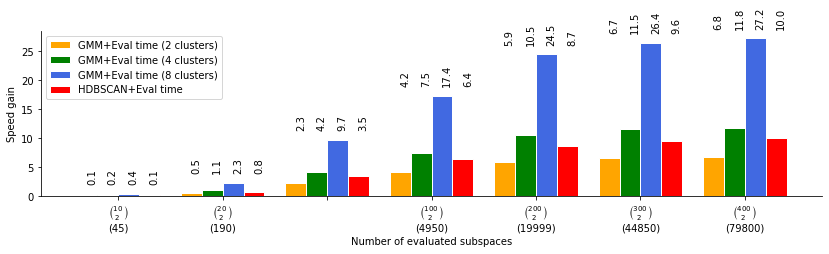

In [11]:
fig = plt.figure(figsize = (14, 4))
ax = plt.gca()
# set width of bar
barWidth = 0.2
 
# set height of bar
bars1 = results['GMM+Eval time (2 clusters)'].values
bars2 = results['GMM+Eval time (4 clusters)'].values
bars3 = results['GMM+Eval time (8 clusters)'].values
bars4 = results['HDBSCAN+Eval time'].values

bars = np.array([bars1, bars2, bars3, bars4])
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='orange', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (2 clusters)')
plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (4 clusters)')
plt.bar(r3, bars3, color='royalblue', width=barWidth, edgecolor='white', 
        label='GMM+Eval time (8 clusters)')
plt.bar(r4, bars4, color='red', width=barWidth, edgecolor='white', 
        label='HDBSCAN+Eval time')

for i in range(bars.shape[1]):
    y = bars[:,i]
    y_pos = max(y)+ 2
    plt.text(i, y_pos, round(y[0],1), rotation = 90)
    plt.text(i + barWidth, y_pos, round(y[1],1),  rotation = 90)
    plt.text(i + 2*barWidth, y_pos, round(y[2],1),  rotation = 90)
    plt.text(i + 3*barWidth, y_pos, round(y[3],1),  rotation = 90)

# Add xticks on the middle of the group bars
plt.xlabel('Number of evaluated subspaces')
plt.xticks([r + 1.5*barWidth for r in range(len(bars1))], results['Nb. evaluations'].values.astype(int))
plt.ylabel("Speed gain")
# plt.suptitle("Number of times the network is faster than traditional clustering + evaluation" +
#     "\nOn exhausive 2D subspace exploration of datasets with 10, 20, 50, 100, 200, 300 and 400 features")
sns.despine()
# Create legend & Show graphic
plt.legend()
# plt.tight_layout()
fig.subplots_adjust(wspace=0.3, top = 0.7)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.savefig("../images/NN_speed_comparaison.pdf", bbox_inches='tight')
